In [3]:
## Import block
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
from numpy import linalg as LA
import pandas as pd

import random 

from sklearn.svm import SVC
from sklearn.datasets import make_circles

## Part 1: What is an SVM
SVMs are Support Vector Machines. These are a type of supervised classification algorithm, meaning the goal is to sort data into groups using a model trained on data where their group placement is known. For instance, we can use this to sort files into benign and malware, by training an SVM on a list of files that are already classified as malware or benign. SVM's do this by trying to find the best boundary between groups of datapoints. First let's visualize this with a 2 dimensional example for convenience.

In [4]:
## Functions for later use

def assign_class(datapoint, slope, intercept):
    # if the point's y coord is less than its x*slope + intercept
    # assign class -1
    if datapoint[1] > datapoint[0]*slope + intercept:
        return -1
    else: return 1

def classification_mse(class_truth, pred_class):
    indicators = np.zeros(len(class_truth))
    index = class_truth == pred_class
    indicators[index] = 0
    indicators[~index] = 1
    return np.mean(indicators)

In [6]:
## Import Example Data

new_data = pd.read_csv("svmToyData.csv", sep = ",")
new_data["group"] = -1*new_data["group"]
new_data_np = np.genfromtxt("svmToyData.csv", delimiter=',', skip_header=1)


extra_data = pd.read_csv("extraSVMToyData.csv", sep = ",")
extra_data["group"] = -1*extra_data["group"]
extra_data_np = np.genfromtxt("extraSVMToyData.csv", delimiter=',', skip_header=1)

## x-values for plotting
x = np.linspace(-3.1,3.15,1000)

print(new_data.head())

       myst     mysty  group
0 -1.061952  1.027354      1
1  0.609315  3.559968      1
2 -0.840217  1.590104      1
3 -1.073169  1.887993      1
4 -0.186200  2.250514      1


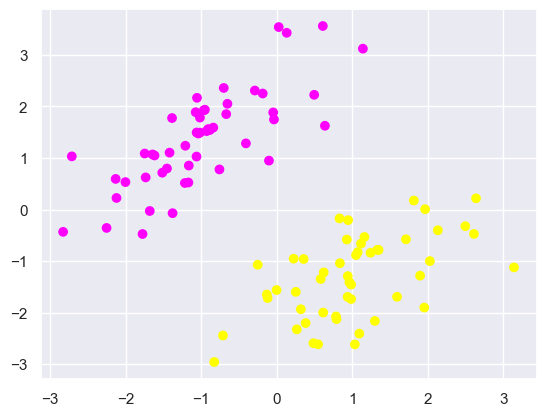

In [ ]:
# Plot new_data
plt.scatter(new_data_np[:, 0],new_data_np[:, 1], c = new_data_np[:, 2], cmap = "spring")

We can see that this data is clearly divided into two groups based on its x and y values. Now our goal is to find the line that divides these two territories. 

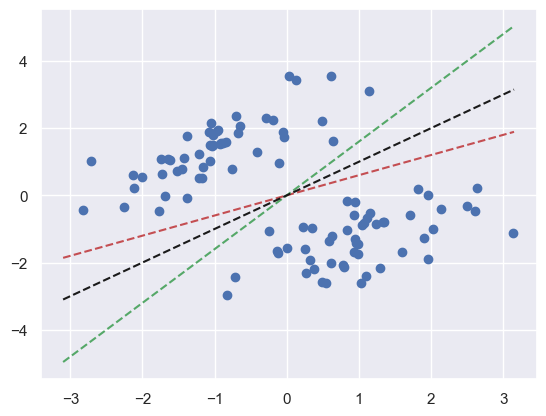

In [ ]:
# Possible boundaries:

# Plot the data
plt.scatter(new_data["myst"],new_data["mysty"])

# Plot one possible option to divide the two groups
# In this case y = 0.6x
plt.plot(x,0.6*x,linestyle='dashed',c="r")

# Plot another possible option to divide the two groups: 
# In this case y = 1.6x
plt.plot(x,1.6*x,linestyle='dashed',c="g")

# third possible line option
plt.plot(x,x,linestyle='dashed',c="k")

So clearly there are several possible options. How do we pick the best one? SVM's pick the line with the largest _margin_, meaning the greatest distance from the datapoints. We can visualize a margin like so:

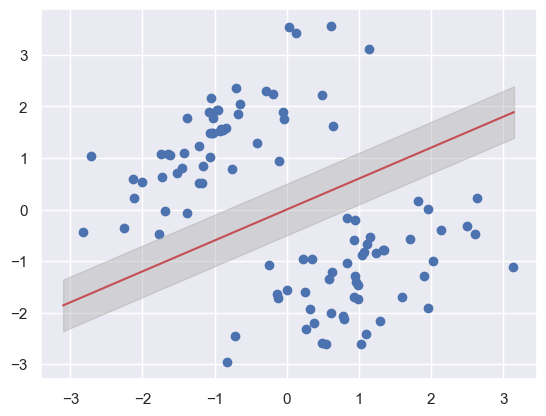

In [ ]:
# Inflating the red boundary:
inflate_width = 0.5

# Plot the data points 
plt.scatter(new_data["myst"],new_data["mysty"])

# Plot the boundary 
plt.plot(x,0.6*x,'-r')

#Plot the "inflation" around the line
plt.fill_between(x, 0.6*x - inflate_width, 0.6*x + inflate_width, 
                 edgecolor='none', color='#AAAAAA', alpha=0.4)

The largest margin that can fit between the two groups without touching data points from either is also called the maximal margin. The task of finding the central line with the maximal margin involves some complex math which thankfully is done for us in modules that implement SVM's such as sklearn.

## Margin Violations
Say we have found a line with the maximal margin. We may be curious how this line performs on new data. Using the extra SVM toy data provided, check how the line performs:


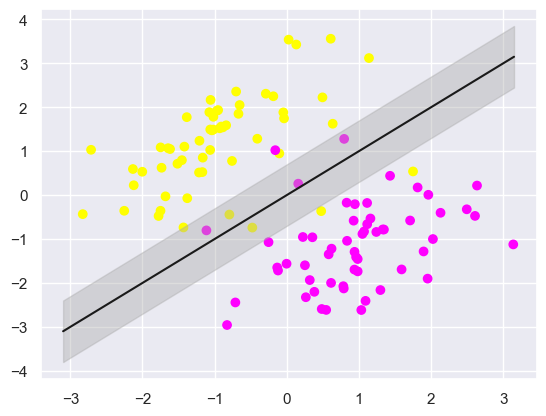

In [ ]:
# Training data
plt.scatter(new_data["myst"],new_data["mysty"], 
            c=new_data["group"], cmap = "spring")

# Testing data
plt.scatter(extra_data["myst"],extra_data["mysty"], 
            c=extra_data["group"], cmap = "spring")

## Your line and inflated part here - 
# You need to fill in which line r (y = 0.6x), g (y = 1.6x), 
# k (y = x) is the best one based on your thoughts from above
inflate_width = .7
plt.plot(x, x, '-k') 
plt.fill_between(x, x - inflate_width, x + inflate_width, 
                 edgecolor='none', color='#AAAAAA', alpha=0.4)

Some points from each group don't stay on their side of the margin! We can see some points entirely on the other side of the line (meaning they would be misclassified), and some that are merely within the margin. Both are considered "violations" of the maximal margin, but the entirely misclassified points are worse.

### Maximal Margins to SVM
SVM seeks to find the widest possible margin while limiting the violations to the bounday. The central line within the margin is called the _decision boundary_. Points within the margin are called _slack variables_, of which there are two groups. The first is variables on the wrong side of the decision boundary, the second is those on the right side of the boundary, but within the margin. Slack variables accumulate penalties denoted $\xi_i$ (pronounced "ex-cee"). A slack variable on the wrong side of the decision boundary incurs a cost greater than 1. A slack variable on the right side but within the boundary incurs a cost between 0 and 1. In SVM, we want the largest possible margin size while limiting the cost of the slack variables $\sum \xi_i$, which is called the _penalty term_. We can control how heavily these penalties are weighted with a parameter $C>0$, rewriting our penalty term as $C \sum \xi_i$. The greater the value of C, the more costly slack variables will be. The actual implementation of this requires a lot of calculus, but we don't need to understand that to use the algorithm, which we will do in part 2.

# Part 2: SVM for Malware Detection

The following code applies an SVM algorithm to the malware/benign dataset. We use the SVM algorithm provided by sklearn. Note that is model is called an SVC (support vector classifier) instead, although they are usually called SVM's.

We start by loading and checking out the data.

In [7]:
# Import dataset
files = pd.read_csv("dataset_malwares.csv")

In [8]:
files.head()
print(len(files))

19611


In [12]:
malware = files['Malware']
files = files.drop(columns=['Malware'])
files.insert(loc=78, column='Malware', value=malware)

files_np = np.array(files)
files_np = files_np[:, 2:].astype('float')

# split data into train and test:
train_index = random.choices(range(len(files_np)), k=17650)
train = files_np[train_index]

testing_index = list(set(range(len(files_np)))-set(train_index))
test = files_np[testing_index, :]


The first step is to define the model that will be used. SKlearn's implementation takes in two arguments: kernel, which is the way the model thinks about distance between two points. Types of kernels include linear, which we have seen in the example of the linear decision bounday, 'rbf', which considers a points distance from the origin (and so is good at classifying circular groups, for instance), and polynomial kernels, which use an additional optional flag for their degree.

In [13]:
svm = SVC(kernel="rbf", C=1E6)


In [14]:
svm.fit(train[:, :-1], train[:, -1])

SVC(C=1000000.0)

In [23]:
# illustrating how the prediction step works
print(svm.predict(files_np[:10, :-1]))
print(files_np[:10, -1])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
# testing our model 
predictions = svm.predict(test[:, :-1])
print(classification_mse(test[:, -1], predictions))


0.17664068393261254


This classifier appears to accurately classify the files around 82% of the time. Some methods to make this classifier more accurate could be cross-validating different models to find the best hyper-parameters to use to build the model with. Using a larger data set could also help. It is also possible that a SVM is not the best classifier model to use here, and another algorithm would be preferable, like a decision tree or kNN. However, this suffices to demonstrate how SVM can be used and the relevance of machine learning to the task of malware detection.